<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/ensemble_baseline_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-6zktxet5/base-rbt_59ec9d0d06954e9bb612195a307f921b
  Running command git clone -q https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-6zktxet5/base-rbt_59ec9d0d06954e9bb612195a307f921b
     |████████████████████████████████| 569 kB 4.9 MB/s 
     |████████████████████████████████| 41 kB 726 kB/s 
     |████████████████████████████████| 549 kB 94.4 MB/s 
     |████████████████████████████████| 182 kB 76.1 MB/s 
  Created wheel for base-rbt: filename=base_rbt-0.0.1-py3-none-any.whl size=16049 sha256=cafb30f48553bba3baa097288768a64f1d82af32a0d7d76b763ecdac890af2c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-cmcz4b31/wheels/b3/25/be/8368facea57a956938db327bdd708e7f93ca5738de036e2c6e
Successfully built base-rbt


In [75]:
from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

In [76]:
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

Step 1): We need the data, and to set all the hps. 

In [77]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
seed=100 #Will have to try with different random seeds. Two times is probably enough 
n_in=1
n_out=10
indim=1024 #find this by inspection, e.g. for resnet18 is 1024
size=28
ps=1024 #Will also try with other values e.g. 125, 1000 etc
bs=128 #for training BT
bs_val=20 #for training linear head
bs_test=500 #divides 10000
ts_val=bs_val #but apparently we don't need it for current setting
ts=10*bs #since ensemble, want smaller amount of data

n_epochs=800 #epochs for BT 
numfit = 200 #epochs for linear classifer

In [78]:
#Let's get MNIST data in a nicer way
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort()
seed_everything(seed=seed)
items=items.shuffle()
label_func=RegexLabeller(pat = r'/training/(\d)/')
labels = [label_func(i) for i in items]

items_train = items[0:ts] #train on ts samples
labels_train = labels[0:ts]
dls_train = ImageDataLoaders.from_lists(path,items_train, labels_train,bs=bs,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,item_tfms=[ToTensor()],
                                  img_cls=PILImageBW)
#items to select the tune_sets
items_tune = items[ts:ts+3000]
labels_tune = labels[ts:ts+3000]

#test set
label_func_test=RegexLabeller(pat = r'/testing/(\d)/')
items_test = get_image_files(path/'testing') #i.e. NOT testing!!!


labels_test = [label_func_test(i) for i in items_test]
dls_test = ImageDataLoaders.from_lists(path,items_test, labels_test,bs=bs_test,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,
                                  img_cls=PILImageBW
                                      )

def tune_set(items0,seed=42,IDs=None):

    seed_everything(seed=seed)
    items=items0.shuffle()
    raw=[]
    if IDs is None:
        IDs=[]
    items_tune20 = []
    labels_tune20 = []

    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}

    for i in items:
        
   
        ID = i.name.strip('.png') #unique identifier
    
        label = label_func(i)
        if (d[label] == 0 or d[label] == 1) and (ID not in IDs):
            items_tune20.append(i)
            labels_tune20.append(label)
            d[label] += 1
            raw.append(i)
            IDs.append(ID)
            
        if len(raw)==20: #once we have 20 (unique!) guys we are done
            break
            

    dls_val = ImageDataLoaders.from_lists(path, items_tune20, labels_tune20,bs=20,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,
                                      img_cls=PILImageBW)

    d = {'items_tune20':items_tune20,'labels_tune20':labels_tune20,'raw':raw,'IDs':IDs,'dls_val':dls_val}
    
    return d


def get_unique_val_set(items0,seed,num=10):
    
    D={}
    IDs=[]
    
    for i in range(num):
        
        dls_val_dict = tune_set(items0,seed=seed+i,IDs=IDs)
        IDs = IDs + dls_val_dict['IDs']
        D[i] = dls_val_dict['dls_val']
    
    return D
        
    
DLS_VAL = get_unique_val_set(items_tune,seed=seed,num=10)

In [79]:
class P4BarlowTwinsModel(Module):

    def __init__(self,model,encoder2,projector2):
        self.model = model #frozen model
        self.encoder2 = encoder2
        self.projector2 = projector2

        
    def forward(self,x,y):
        
        return self.model(x),self.projector2(self.encoder2(x))

def create_p4barlow_twins_model(model,encoder2, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder2)
    with torch.no_grad(): representation = encoder2(torch.randn((2,n_in,128,128)))
    
    
    projector2 = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector2)
    
    
    return P4BarlowTwinsModel(model=model,encoder2=encoder2,projector2=projector2)


In [80]:
class BarlowTwinsEns(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in,t=0.1,lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.n_in=n_in
        self.t=t
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector2[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:

            #Two distorted views according to first augmentation distribution
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug1(TensorImageBW(self.x))
          
            #Two distorted views according to second augmentation distribution
            #xi_2,xj_2 = self.aug2(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))


        elif self.n_in == 3:
            
            assert False
            
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
            
        
        #self.learn.xb = (torch.cat([xi, xj]),torch.cat([xi_2, xj_2]))
        self.learn.xb = (torch.cat([xi, xj]),torch.cat([xi, xj]))

    def before_epoch(self):
        pass
        # if self.epoch <=10:
        #     self.t=0.2

        # if self.epoch == 10:
        #     self.t=0.1

        # if self.epoch == 20:
        #     self.t=0.05

        # if self.epoch == 30:
        #     self.t=0.025

        # if self.epoch == 100:
        #     self.t=0.0125

        # if self.epoch == 400:
        #     self.t= 0.005

        # if self.epoch == 600:
        #     self.t=0.0005


    @torch.no_grad()
    def show(self, n=1):
        
        x=self.learn.x[0]
        y=self.learn.x[1]
        
        bs = x.size(0)//2
        x1,x2  = x[:bs], x[bs:]
        y1,y2  = y[:bs], y[bs:]
        
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug1.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        
        y1 = self.aug1.decode(y1[idxs].to('cpu').clone()).clamp(0,1)
        y2 = self.aug1.decode(y2[idxs].to('cpu').clone()).clamp(0,1)
        
        images = []
        for i in range(n): images += [x1[i],x2[i],y1[i],y2[i]]
        show_batch(x1[0], None, images, max_n=len(images), nrows=n)

        return


In [ ]:
def show_btens_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
        
    learn = Learner(dls,model=None, cbs=[BarlowTwinsEns(aug,n_in=n_in,print_augs=print_augs)])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.barlow_twins_ens.show(n=n)

In [81]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def lf_rbt_ens(pred,I,lmb,
               t,
               ):

    
    pred1 = pred[0] #frozen
    pred2 = pred[1] #has gradients


    
    bs,nf = pred1.size(0)//2,pred1.size(1)

    #All standard, from BT
    z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / (z1.std(0, unbiased=False) + 1e-7)
    z2norm = (z2 - z2.mean(0)) / (z2.std(0, unbiased=False) + 1e-7)
    
    z1_2, z2_2 = pred2[:bs],pred2[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_2 = (z1_2 - z1_2.mean(0)) / (z1_2.std(0, unbiased=False) + 1e-7)
    z2norm_2 = (z2_2 - z2_2.mean(0)) / (z2_2.std(0, unbiased=False) + 1e-7)
    
    test_eq(pred1.requires_grad,False)
    test_eq(pred2.requires_grad,True)


    #Within frozen model 
    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2
    
    #Within model_2
    C = (z1norm_2.T @ z2norm_2) / bs 
    cdiff_2 = (C - I)**2

    #Now, first thought is that we want the representations to be negatively correlated

    cross_1 = (z1norm * z1norm_2).sum(0) / bs

    cross_2 = (z2norm * z2norm_2).sum(0) / bs

    #between = 0.5*(cross_1 + 1).pow(2) + 0.5*(cross_2+1).pow(2) #between model correlation -> we want to be negative

    between = 0.5*cross_1 + 0.5*cross_2 #i.e. same way as in the paper...

    loss = (cdiff_2*I).sum() + lmb*(cdiff_2*(1-I)).sum() #standard BT loss for learnable model

    loss = loss + t*between.sum()

    torch.cuda.empty_cache()
    return loss

In [82]:
# #Using RBT_enc
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

Setup for linear evaluation:

In [83]:
#Augmentation pipeline: just random resized crop and normalization
aug_pipelines_val=[get_linear_batch_augs(size=28,stats=mnist_stats,resize=True,resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3))]

Optional: Show linear augmentations:

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: 


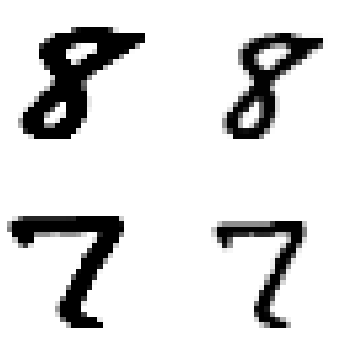

In [ ]:
#Use same dls each time so we can see how augmentation is varying
_dls = ImageDataLoaders.from_lists(path,items_train[0:20], labels_train[0:20],bs=20,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,item_tfms=[ToTensor()],
                                  img_cls=PILImageBW)

#The first column is the augmented view (fed to learner - i.e. linear model; second
#column is the un-augmented view.)
show_linear_batch(dls=_dls,n_in=n_in,n=2,aug=aug_pipelines_val,print_augs=True)

Example of augmentations for ensemble. Probably use these. 

In [84]:
blur_r=(0.9,1.2)
noise_std=0.25
rotate_deg=45
rotate_p=0.9
noise_p=0.5
blur_p=0.5

#tau1
aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=28,blur_r=blur_r,
                    rotate=False,jitter=False,noise=True,bw=False,blur=False,solar=False, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=noise_std, rotate_deg=rotate_deg,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=rotate_p,noise_p=noise_p, jitter_p=0.3, bw_p=0.3, blur_p=blur_p,sol_p=0.25, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

#tau2
aug_pipelines_2  =  get_barlow_twins_aug_pipelines(size=28,blur_r=blur_r,
                    rotate=True,jitter=False,noise=False,bw=False,blur=False,solar=False, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=noise_std, rotate_deg=rotate_deg,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=rotate_p,noise_p=noise_p, jitter_p=0.3, bw_p=0.3, blur_p=blur_p,sol_p=0.25, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

#"union" of 1 and 2 -> tau12
aug_pipelines_12  =  get_barlow_twins_aug_pipelines(size=28,blur_r=blur_r,
                    rotate=True,jitter=False,noise=True,bw=False,blur=False,solar=False, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=noise_std, rotate_deg=rotate_deg,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=rotate_p,noise_p=noise_p, jitter_p=0.3, bw_p=0.3, blur_p=blur_p,sol_p=0.25, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

aug_pipelines = [aug_pipelines_1,aug_pipelines_1]

Step 3): (Optional): View the augmentations:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}


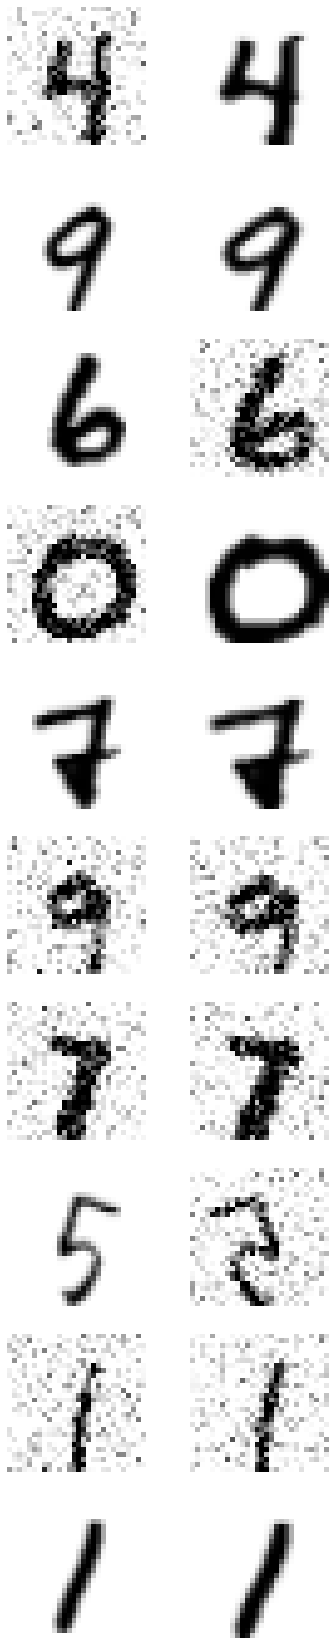

In [ ]:
#View the augmentations the "usual way"
show_bt_batch(dls=dls_train,n_in=n_in,aug=aug_pipelines,n=10,print_augs=True)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}


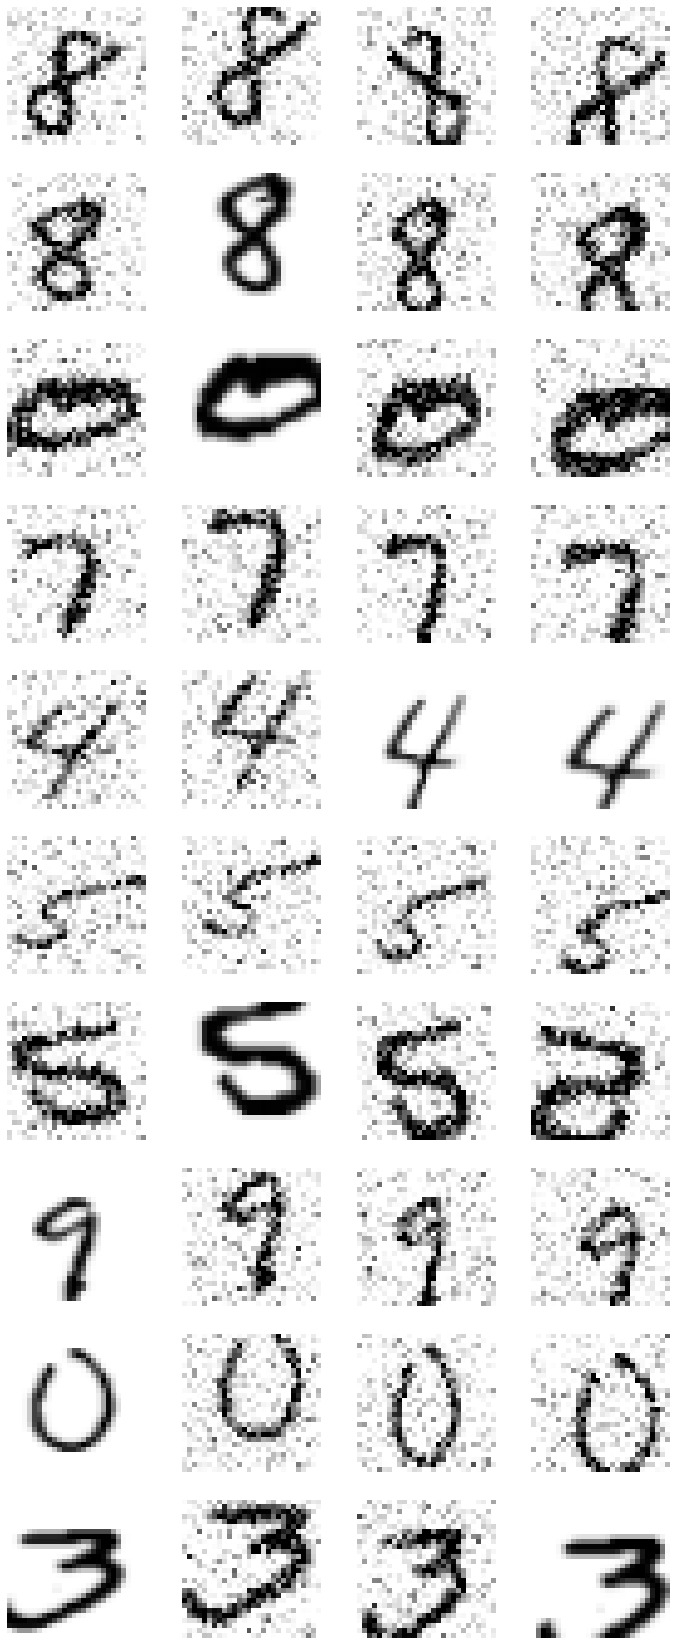

In [ ]:
#view the augmentations the 'ensemble' way
show_btens_batch(dls_train,n_in,aug=aug_pipelines,n=10,print_augs=True)

Next is stuff we need to train the ensembles:

TODO: Right approach might be to define a custom dataloader where we don't have load each time... Or something like that. 

In [85]:
#train and evaluate ensemble of heads, given two fixed encoders

#NOTE: has been refactored. Rewrite Main_Linear_Eval to include e.g. n_out.
class Main_Linear_Ensemble_Eval(Main_Linear_Eval):
    def __init__(self,size,n_in,indim,numfit, #size e.g. 32, n_in e.g. 1 or 3, indim  is encoder output dim, numfit number of epochs training 
                 dls_val,dls_test, #dls_val for training linear, dls_test for evaluation
                 stats, #e.g. cifar_stats
                 aug_pipelines_val, #generally simple (crop and normalizatiom)
                 n_out,
                 encoder,encoder_2,
                 x,y,
                ):
        
        super().__init__(size,n_in,indim,numfit, #size e.g. 32, n_in e.g. 1 or 3, indim  is encoder output dim, numfit number of epochs training 
                 dls_val,dls_test, #dls_val for training linear, dls_test for evaluation
                 stats, #e.g. cifar_stats
                 aug_pipelines_val,encoder)
        
        self.encoder_2 = encoder_2
        if self.encoder_2 is not None:
            self.model_2 = LinearModel(encoder=self.encoder_2,indim=indim)

        self.n_out=n_out
        self.x=x
        self.y=y
        self.criterion = nn.CrossEntropyLoss()
        
        if device=='cuda':
            self.model = self.model.cuda()
            self.model_2 = self.model_2.cuda()


    def fit_head(self,
                 model #frozen encoder in eval model, followed by trainable head
                 ):

        #head = nn.Linear(self.n_in,self.n_out)


        opt = Adam(model.parameters(),lr=0.001)
 
        for epoch in range(self.numfit):

            x = self.aug_pipelines_val[0](self.x)
            out = model(x)
            loss = self.criterion(out,self.y)
            opt.zero_grad()
            loss.backward()
            opt.step()

#             #hacky hook to 'manually' decrease learning rate towards the end 
#             if epoch==int(0.75*self.numfit): #so for last 50 epochs if numfit is 200
#                 opt.hypers[0]['lr']=0.0005

        print(loss.item()) #should be quite small
        print('head trained')

    #Eval_Model is the same as in Main_Linear_Eval
    
    #We need to rewrite this guy to take in two models now (average predictions)
    def eval_linear(self):

        eval_model = self.Eval_Mode(self.model)
        eval_model_2 = self.Eval_Mode(self.model_2)
        
        N=len(self.dls_test.train)*self.dls_test.bs
        test_eq(N,len(self.dls_test.train_ds)) #check that batch size divides length of test set
        
        num_correct=0
        for x,y in self.dls_test.train:

            ypred = 0.5*eval_model(x)  + 0.5*eval_model_2(x)

            correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
            num_correct += correct.sum()

        accuracy = num_correct/N
        return accuracy.item()
    
    def __call__(self):
        

        #Eventually
        #train linear classifier on dls_eval. Requires inputs: encoder, aug_pipeline, dls, 
        #bt = LinearBt(self.aug_pipelines_val,show_batch=True,n_in=self.n_in,print_augs=False)
        #learn = Learner(self.dls_val,self.model, cbs=[bt])
        # with learn.no_bar(), learn.no_logging():
        #     learn.fit(self.numfit)
        
        # bt_2 = LinearBt(self.aug_pipelines_val,show_batch=True,n_in=self.n_in,print_augs=False)
        # learn_2 = Learner(self.dls_val,self.model_2, cbs=[bt_2])
        # with learn_2.no_bar(), learn_2.no_logging(): 
        #     learn_2.fit(self.numfit)

        #train first head, on encoder(x)
        self.fit_head(model=self.model)

        #train second head, on encoder_2(x)
        self.fit_head(model=self.model_2)
            
        #eval linear classifier
        acc = self.eval_linear() #Is now average
        
        return acc

In [86]:
#Train the encoders: New methodology 1)train one encoder standard way (BT). 2) Train second network, attempting to make
#"decorrelated" from first network, during training
def train_rbt(t,model,aug_pipelines):
        
    @patch
    def lf(self:BarlowTwinsEns, pred,*yb): return lf_rbt_ens(pred,I=self.I,lmb=self.lmb,t=self.t) #pass them to loss function
  
    #train the first encoder in the standard way
    #fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
    #model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
    #learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
    #learn.fit(n_epochs)

    #put into eval model and turn OFF gradients
    model.eval()
    model = grad_on(fastai_encoder,on=False)


    fastai_encoder_2 = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
    model = create_p4barlow_twins_model(model,fastai_encoder_2, hidden_size=ps,projection_size=ps,nlayers=3)
    learn = Learner(dls_train,model, cbs=[BarlowTwinsEns(aug_pipelines,n_in=n_in,t=t,lmb=1/ps,print_augs=False)])
    
    #with learn.no_bar(), learn.no_logging(): 
    learn.fit(n_epochs)

    return model,fastai_encoder,fastai_encoder_2


In [87]:
#Evaluate the encoders by tuning on several tune-valid sets and then testing on test set
def tune_valid(fastai_encoder,fastai_encoder_2,DLS_VAL=None):
    fastai_encoder.eval() #eval mode
    fastai_encoder = grad_on(fastai_encoder,on=False) #turn off gradients
    
    fastai_encoder_2.eval() #eval mode
    fastai_encoder_2 = grad_on(fastai_encoder_2,on=False) #turn off gradients
    
    N=len(DLS_VAL)
    acc_dict={}
    for i in range(N):
        
        #dls_val = tune_set(items_tune,seed=seed+i)['dls_val']
        dls_val=DLS_VAL[i]
        x,y = dls_val.train.one_batch()
        
        main_linear_eval = Main_Linear_Ensemble_Eval(size=size,n_in=n_in,numfit=numfit,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                                dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                                stats=mnist_stats,
                                aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                                encoder=fastai_encoder,
                                encoder_2=fastai_encoder_2,
                                n_out=n_out,
                                x=x,
                                y=y
                                )
                
        #main_linear_eval.encoder = self.encoder (usage within BT training)
        acc=main_linear_eval()
        
        acc_dict[i]=acc

        #print(f'On tune set {i} we had acc of {acc}. The acc_dict is currently: {acc_dict}')

        
    acc_dict['mean'] = (sum(list(acc_dict.values()))/len(acc_dict.values()))
    #print((sum(list(acc_dict.values()))/len(acc_dict.values())))
    
    return acc_dict

In [88]:
@patch
def lf(self:BarlowTwinsEns, pred,*yb): return lf_rbt_ens(pred,I=self.I,lmb=self.lmb,t=self.t) #pass them to loss function

In [ ]:
# #Train the encoders: New methodology 1)train one encoder standard way (BT). 2) Train second network, attempting to make
# #"decorrelated" from first network, during training
# def train_rbt(t,aug_pipelines,fastai_encoder=None,model=None):
        
#     @patch
#     def lf(self:BarlowTwinsEns, pred,*yb): return lf_rbt_ens(pred,I=self.I,lmb=self.lmb,t=self.t) #pass them to loss function
  
#     #train the first encoder in the standard way
#     if model==None:
#         fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
#         model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
#         learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
#         learn.fit(n_epochs)

#     #put into eval model and turn OFF gradients
#     model.eval()
#     model = grad_on(fastai_encoder,on=False)


#     fastai_encoder_2 = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
#     model = create_p4barlow_twins_model(model,fastai_encoder_2, hidden_size=ps,projection_size=ps,nlayers=3)
#     learn = Learner(dls_train,model, cbs=[BarlowTwinsEns(aug_pipelines,n_in=n_in,t=t,lmb=1/ps,print_augs=False)])
    
#     #with learn.no_bar(), learn.no_logging(): 
#     learn.fit(n_epochs)

#     return model,fastai_encoder,fastai_encoder_2

Here is the entire API for training our ensemble:

In [89]:
aug_pipelines = [aug_pipelines_12,aug_pipelines_12]
hp_vals = [(0.05,)]

class RBT_Ensemble:

    def __init__(self,hp,aug_pipelines,model=None,fastai_encoder=None,DLS_VAL=None): store_attr()

    
    def train_rbt(self):
        "Train encoders"

        t=self.hp[0]
        aug_pipelines = self.aug_pipelines
        model = self.model
        fastai_encoder = self.fastai_encoder

            #train the first encoder in the standard way
        if model==None:
            fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
            model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
            learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
            learn.fit(n_epochs)

        #put into eval model and turn OFF gradients
        model.eval()
        model = grad_on(fastai_encoder,on=False)

        fastai_encoder_2 = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
        model = create_p4barlow_twins_model(model,fastai_encoder_2, hidden_size=ps,projection_size=ps,nlayers=3)
        learn = Learner(dls_train,model, cbs=[BarlowTwinsEns(aug_pipelines,n_in=n_in,t=t,lmb=1/ps,print_augs=False)])
        
        #with learn.no_bar(), learn.no_logging(): 
        learn.fit(n_epochs)

        return model,fastai_encoder,fastai_encoder_2

    def __call__(self):
        "Wrapper to train encoders; then train heads"
 
        model,fastai_encoder,fastai_encoder_2 = self.train_rbt() #train encoders

        acc_dict=tune_valid(fastai_encoder,fastai_encoder_2,DLS_VAL=DLS_VAL) #train and evaluate ensemble of heads

        acc_dict['model'] = model
        acc_dict['fastai_encoder'] = fastai_encoder 
        acc_dict['fastai_encoder_2'] = fastai_encoder_2

        return acc_dict 

if __name__ == '__main__':
    RBT_ENSEMBLE = {}
    for hp in hp_vals:
        
        #rbt_ensemble = RBT_Ensemble(hp=hp,aug_pipelines=aug_pipelines,model=acc_dict['model'],fastai_encoder=acc_dict['fastai_encoder'],DLS_VAL=DLS_VAL)
        rbt_ensemble = RBT_Ensemble(hp=hp,aug_pipelines=aug_pipelines,model=None,fastai_encoder=None,DLS_VAL=DLS_VAL)

        acc_dict = rbt_ensemble()
        
        RBT_ENSEMBLE[hp] = acc_dict
        print(f"With hps {hp} total results are {acc_dict} with mean {acc_dict['mean']}") #print out results as we go

    for hp_vals in RBT_ENSEMBLE.keys():
        print(f"With hps {hp_vals} total results are {RBT_ENSEMBLE[hp_vals]} with mean {RBT_ENSEMBLE[hp_vals]['mean']}\n") #print out final results 
       
print("Fixed t")
RBT_ENSEMBLE #Display final (total) results


epoch,train_loss,valid_loss,time
0,468.695587,None,00:01
1,368.311035,None,00:01
2,311.084534,None,00:01
3,279.419830,None,00:01


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


KeyboardInterrupt: ignored

Here is the entire API for training our ensemble:

In [ ]:
# aug_pipelines = [aug_pipelines_12,aug_pipelines_12]
# hp_vals = [(0.1,)] 
 
# def train_RBT_ensemble(hp,model=None,fastai_encoder=None,DLS_VAL=None):
#     "Wraps training encoders (`train_rbt`) with training head (`tune_valid`)"

#     model,fastai_encoder,fastai_encoder_2=train_rbt(t=hp[0],model=model,fastai_encoder=fastai_encoder,aug_pipelines=aug_pipelines) #train ensemble

#     acc_dict=tune_valid(fastai_encoder,fastai_encoder_2,DLS_VAL=DLS_VAL) #train and evaluate ensemble of heads

#     acc_dict['model'] = model
#     acc_dict['fastai_encoder'] = fastai_encoder

#     return acc_dict

# if __name__ == '__main__':
#     RBT_ENSEMBLE = {}
#     for hp in hp_vals:
        
#         #skip guys have already done on grid
#         # if hp in completed_hp_vals:
#         #     continue

#         acc_dict = train_RBT_ensemble(hp,DLS_VAL=DLS_VAL,model,fastai_encoder)
#         RBT_ENSEMBLE[hp] = acc_dict
#         print(f"With hps {hp} total results are {acc_dict} with mean {acc_dict['mean']}") #print out results as we go

#     for hp_vals in RBT_ENSEMBLE.keys():
#         print(f"With hps {hp_vals} total results are {RBT_ENSEMBLE[hp_vals]} with mean {RBT_ENSEMBLE[hp_vals]['mean']}\n") #print out final results 
       
# print("Fixed t")
# RBT_ENSEMBLE #Display final (total) results

epoch,train_loss,valid_loss,time
0,465.024384,None,00:01
1,396.746796,None,00:01
2,335.469116,None,00:01
3,296.264740,None,00:01
4,269.041962,None,00:01
5,252.195816,None,00:01
6,241.642883,None,00:01
7,228.849625,None,00:01
8,217.112381,None,00:01
9,204.121063,None,00:01


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,683.101013,None,00:01
1,552.613525,None,00:01
2,469.566925,None,00:01
3,419.306274,None,00:01
4,380.225006,None,00:01
5,350.560608,None,00:01
6,328.099304,None,00:01
7,308.406219,None,00:01
8,289.718597,None,00:01
9,274.911865,None,00:01


0.008864698931574821
head trained
0.006323070731014013
head trained
0.003819315927103162
head trained
0.004703695885837078
head trained
0.005345928482711315
head trained
0.0040154485031962395
head trained
0.00580455269664526
head trained
0.0035608909092843533
head trained
0.006933701690286398
head trained
0.0048483447171747684
head trained
0.008558336645364761
head trained
0.005125004332512617
head trained
0.1679324209690094
head trained
0.14362038671970367
head trained
0.006423873361200094
head trained
0.007095023989677429
head trained
0.004225237760692835
head trained
0.0035141955595463514
head trained
0.004865992348641157
head trained
0.015507655218243599
head trained
With hps (0.025,) total results are {0: 0.7214000225067139, 1: 0.8295999765396118, 2: 0.8385999798774719, 3: 0.8281000256538391, 4: 0.8525999784469604, 5: 0.8540999889373779, 6: 0.847599983215332, 7: 0.801800012588501, 8: 0.7925999760627747, 9: 0.8003000020980835, 'mean': 0.8166699945926666, 'model': P4BarlowTwinsModel

{(0.025,): {0: 0.7214000225067139,
  1: 0.8295999765396118,
  2: 0.8385999798774719,
  3: 0.8281000256538391,
  4: 0.8525999784469604,
  5: 0.8540999889373779,
  6: 0.847599983215332,
  7: 0.801800012588501,
  8: 0.7925999760627747,
  9: 0.8003000020980835,
  'mean': 0.8166699945926666,
  'model': P4BarlowTwinsModel(
    (model): Sequential(
      (0): ConvLayer(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ConvLayer(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
model = acc_dict['model']
fastai_encoder = acc_dict['fastai_encoder']


Current hacking:

In [ ]:
#t is fixed, is weight to negative correlation

#First network has (individual) performance:
{0: 0.7287999987602234,
 1: 0.8172000050544739,
 2: 0.8323000073432922,
 3: 0.7892000079154968,
 4: 0.8334000110626221,
 5: 0.8251000046730042,
 6: 0.828499972820282,
 7: 0.7741000056266785,
 8: 0.763700008392334,
 9: 0.7843000292778015,
 'mean': 0.7976600050926208}

#With hps (0.025,) total results are {0: 0.7260000109672546, 1: 0.8348000049591064, 2: 0.8287000060081482, 3: 0.8291000127792358, 4: 0.8456000089645386, 5: 0.8604000210762024, 6: 0.8641999959945679, 7: 0.8019999861717224, 8: 0.7858999967575073, 9: 0.8019000291824341, 'mean': 0.8178600072860718}


Current hacking: Contrastive between model rr term, with exp-log and classical between model invariance term:

Here is the API for training baseline:

In [ ]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

#Choice here: could have both as aug_pipelines_12 instead
def train_BT_ensemble(_augs='disjoint',DLS_VAL=None):
    
    if _augs=='disjoint':
        aug_pipelines_BT1 = [aug_pipelines_1,aug_pipelines_1] #choice here
        aug_pipelines_BT2 = [aug_pipelines_2,aug_pipelines_2] #choice here
    
    elif _augs=='union':
        aug_pipelines_BT1 = [aug_pipelines_12,aug_pipelines_12]
        aug_pipelines_BT2 = [aug_pipelines_12,aug_pipelines_12]
        
    fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
    fastai_encoder_2 = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)

    model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
    learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines_BT1,n_in=n_in,lmb=1/ps,print_augs=False)])

    model_2 = create_barlow_twins_model(fastai_encoder_2, hidden_size=ps,projection_size=ps,nlayers=3)
    learn_2 = Learner(dls_train,model_2, cbs=[BarlowTwins(aug_pipelines_BT2,n_in=n_in,lmb=1/ps,print_augs=False)])

    learn.fit(n_epochs),learn_2.fit(n_epochs) #If we have two GPUS can do this in parallel

    acc_dict=tune_valid(fastai_encoder,fastai_encoder_2,DLS_VAL=DLS_VAL) #train and evaluate ensemble of heads

    return acc_dict

if __name__ == '__main__':
    acc_dict_disjoint_ensemble = train_BT_ensemble(_augs='disjoint',DLS_VAL=DLS_VAL)
    print(f'The results for BT ensemble when training on disjoint augs is: {acc_dict_disjoint_ensemble}\n')
    acc_dict_union_ensemble = train_BT_ensemble(_augs='union',DLS_VAL=DLS_VAL)
    print(f'The results for BT ensemble when training on union of augs is: {acc_dict_union_ensemble}\n')
    

Hi, here are 800 epoch baselines... But I need to double check, especially for union (which seems to be all we are using now anyway.

Also, for a fair comparison we can train one network, then:

1) A second network independently
2) A second network with a "negative correlation term" (whatever that means) with the first one

In [ ]:
#hps using. The augmentations are noise and rotation

blur_r=(0.9,1.2)
noise_std=0.25
rotate_deg=45
rotate_p=0.9
noise_p=0.5

#When training one BT model on tau1 results is {0: 0.6721000075340271, 1: 0.7972999811172485, 2: 0.7215999960899353, 3: 0.7282999753952026, 4: 0.7565000057220459, 5: 0.7339000105857849, 6: 0.7411999702453613, 7: 0.7311999797821045, 8: 0.7045000195503235, 9: 0.6812000274658203, 'mean': 0.7267799973487854}
#When training one BT model on tau2 results is {0: 0.7044000029563904, 1: 0.7832000255584717, 2: 0.8191999793052673, 3: 0.7928000092506409, 4: 0.8227999806404114, 5: 0.800599992275238, 6: 0.7867000102996826, 7: 0.7712000012397766, 8: 0.7563999891281128, 9: 0.73580002784729, 'mean': 0.7773100018501282}
#When training one BT model on tau12 results is {0: 0.7293999791145325, 1: 0.8062000274658203, 2: 0.8065000176429749, 3: 0.8029000163078308, 4: 0.8450999855995178, 5: 0.8607000112533569, 6: 0.8330000042915344, 7: 0.7967000007629395, 8: 0.7696999907493591, 9: 0.7753999829292297, 'mean': 0.8025600016117096}

#The results for BT ensemble when training on disjoint augs is: {0: 0.7258999943733215, 1: 0.8134999871253967, 2: 0.7851999998092651, 3: 0.8016999959945679, 4: 0.8264999985694885, 5: 0.8255000114440918, 6: 0.8270999789237976, 7: 0.7957000136375427, 8: 0.7610999941825867, 9: 0.7378000020980835, 'mean': 0.7899999976158142}
#The results for BT ensemble when training on union of augs is: {0: 0.7357000112533569, 1: 0.8167999982833862, 2: 0.8177000284194946, 3: 0.8371999859809875, 4: 0.8568000197410583, 5: 0.8489999771118164, 6: 0.8501999974250793, 7: 0.8057000041007996, 8: 0.789900004863739, 9: 0.7906000018119812, 'mean': 0.8149600028991699}

#This is annoying... It could be variance?
#When "jointly" training standard BT ensemble on union of augs: {0: 0.6917999982833862, 1: 0.8198000192642212, 2: 0.801800012588501, 3: 0.8162999749183655, 4: 0.8303999900817871, 5: 0.833299994468689, 6: 0.8136000037193298, 7: 0.7856000065803528, 8: 0.7483999729156494, 9: 0.7398999929428101, 'mean': 0.7880899965763092} with mean 0.7880899965763092
 

## So most important result: When training ensemble (on union of augs) got 0.832. When training a single network, got 0.81496. These are the main baselines for now.

BT baselines (no ensemble)

In [ ]:
#Just train one linear head (no ensemble)

#NOTE: has been refactored. Rewrite Main_Linear_Eval to include e.g. n_out.
class Main_Linear_Eval_New(Main_Linear_Eval):
    def __init__(self,size,n_in,indim,numfit, #size e.g. 32, n_in e.g. 1 or 3, indim  is encoder output dim, numfit number of epochs training 
                 dls_val,dls_test, #dls_val for training linear, dls_test for evaluation
                 stats, #e.g. cifar_stats
                 aug_pipelines_val, #generally simple (crop and normalizatiom)
                 n_out,
                 encoder,
                 x,y,
                ):
        
        super().__init__(size,n_in,indim,numfit, #size e.g. 32, n_in e.g. 1 or 3, indim  is encoder output dim, numfit number of epochs training 
                 dls_val,dls_test, #dls_val for training linear, dls_test for evaluation
                 stats, #e.g. cifar_stats
                 aug_pipelines_val,encoder)

        self.n_out=n_out
        self.x=x
        self.y=y
        self.criterion = nn.CrossEntropyLoss()
        
        if device=='cuda':
            self.model = self.model.cuda()


    def fit_head(self,
                 model #frozen encoder in eval model, followed by trainable head
                 ):

        #head = nn.Linear(self.n_in,self.n_out)


        opt = Adam(model.parameters(),lr=0.001)
 
        for epoch in range(self.numfit):

            x = self.aug_pipelines_val[0](self.x)
            out = model(x)
            loss = self.criterion(out,self.y)
            opt.zero_grad()
            loss.backward()
            opt.step()

#             #hacky hook to 'manually' decrease learning rate towards the end 
#             if epoch==int(0.75*self.numfit): #so for last 50 epochs if numfit is 200
#                 opt.hypers[0]['lr']=0.0005


            
        print(loss.item()) #should be quite small
        print('head trained')

        
    #Eval_Model is the same as in Main_Linear_Eval
    
    #We need to rewrite this guy to take in two models now (average predictions)
    def eval_linear(self):

        eval_model = self.Eval_Mode(self.model)        
        N=len(self.dls_test.train)*self.dls_test.bs
        test_eq(N,len(self.dls_test.train_ds)) #check that batch size divides length of test set
        
        num_correct=0
        for x,y in self.dls_test.train:

            ypred = eval_model(x)

            correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
            num_correct += correct.sum()

        accuracy = num_correct/N
        return accuracy.item()
    
    def __call__(self):
        

        #Eventually
        #train linear classifier on dls_eval. Requires inputs: encoder, aug_pipeline, dls, 
        #bt = LinearBt(self.aug_pipelines_val,show_batch=True,n_in=self.n_in,print_augs=False)
        #learn = Learner(self.dls_val,self.model, cbs=[bt])
        # with learn.no_bar(), learn.no_logging():
        #     learn.fit(self.numfit)
        
        # bt_2 = LinearBt(self.aug_pipelines_val,show_batch=True,n_in=self.n_in,print_augs=False)
        # learn_2 = Learner(self.dls_val,self.model_2, cbs=[bt_2])
        # with learn_2.no_bar(), learn_2.no_logging(): 
        #     learn_2.fit(self.numfit)

        #train first head, on encoder(x)
        self.fit_head(model=self.model)            

        #eval linear classifier
        acc = self.eval_linear() #Is now average
        
        return acc

In [ ]:
#Evaluate the encoders by tuning on several tune-valid sets and then testing on test set
def tune_valid_single(fastai_encoder,DLS_VAL=None):
    fastai_encoder.eval() #eval mode
    fastai_encoder = grad_on(fastai_encoder,on=False) #turn off gradients

    N=len(DLS_VAL)
    acc_dict={}
    for i in range(N):
        
        #dls_val = tune_set(items_tune,seed=seed+i)['dls_val']
        dls_val=DLS_VAL[i]
        x,y = dls_val.train.one_batch()
        
        main_linear_eval = Main_Linear_Eval_New(size=size,n_in=n_in,numfit=numfit,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                                dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                                stats=mnist_stats,
                                aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                                encoder=fastai_encoder,
                                n_out=n_out,
                                x=x,
                                y=y
                                )
                
        #main_linear_eval.encoder = self.encoder (usage within BT training)
        acc=main_linear_eval()
        
        acc_dict[i]=acc

        #print(f'On tune set {i} we had acc of {acc}. The acc_dict is currently: {acc_dict}')

    acc_dict['mean'] = (sum(list(acc_dict.values()))/len(acc_dict.values()))
    #print((sum(list(acc_dict.values()))/len(acc_dict.values())))
    
    return acc_dict

In [ ]:
#Training fastai_encoder from above

fastai_encoder = acc_dict['fastai_encoder']
tem_acc_dict=tune_valid_single(fastai_encoder,DLS_VAL=DLS_VAL) #train and evaluate ensemble of heads
tem_acc_dict

0.015351134352385998
head trained
0.0036876413505524397
head trained
0.01699697971343994
head trained
0.004737524315714836
head trained
0.010144735686480999
head trained
0.02435210905969143
head trained
0.011692185886204243
head trained
0.009191633202135563
head trained
0.007902913726866245
head trained
0.055623628199100494
head trained


{0: 0.7287999987602234,
 1: 0.8172000050544739,
 2: 0.8323000073432922,
 3: 0.7892000079154968,
 4: 0.8334000110626221,
 5: 0.8251000046730042,
 6: 0.828499972820282,
 7: 0.7741000056266785,
 8: 0.763700008392334,
 9: 0.7843000292778015,
 'mean': 0.7976600050926208}

In [ ]:
#Let's train a single BT model (no ensemble) as baseline

def train_single_BT(aug_pipelines,fastai_encoder=None):

    #fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
    #model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
    #learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
    #learn.fit(n_epochs)
    acc_dict=tune_valid_single(fastai_encoder,DLS_VAL=DLS_VAL) #train and evaluate ensemble of heads
    acc_dict

    return acc_dict

if __name__ == '__main__':

    aug_pipelines = [aug_pipelines_1,aug_pipelines_1]
    acc_dict = train_single_BT(aug_pipelines)
    print(f'When training one BT model on tau1 results is {acc_dict}')

    aug_pipelines = [aug_pipelines_2,aug_pipelines_2]
    acc_dict = train_single_BT(aug_pipelines)
    print(f'When training one BT model on tau2 results is {acc_dict}')

    aug_pipelines = [aug_pipelines_12,aug_pipelines_12]
    acc_dict = train_single_BT(aug_pipelines)
    print(f'When training one BT model on tau12 results is {acc_dict}')



In [ ]:
model = acc_dict['model']
dir(model)
#single_acc_dict=tune_valid_single(fastai_encoder,DLS_VAL=DLS_VAL)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pre_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__signature__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_for

800 epochs, baselines:

In [ ]:
#hps using. The augmentations are noise and rotation

blur_r=(0.9,1.2)
noise_std=0.25
rotate_deg=45
rotate_p=0.9
noise_p=0.5

#When training one BT model on tau1 results is {0: 0.6721000075340271, 1: 0.7972999811172485, 2: 0.7215999960899353, 3: 0.7282999753952026, 4: 0.7565000057220459, 5: 0.7339000105857849, 6: 0.7411999702453613, 7: 0.7311999797821045, 8: 0.7045000195503235, 9: 0.6812000274658203, 'mean': 0.7267799973487854}
#When training one BT model on tau2 results is {0: 0.7044000029563904, 1: 0.7832000255584717, 2: 0.8191999793052673, 3: 0.7928000092506409, 4: 0.8227999806404114, 5: 0.800599992275238, 6: 0.7867000102996826, 7: 0.7712000012397766, 8: 0.7563999891281128, 9: 0.73580002784729, 'mean': 0.7773100018501282}
#When training one BT model on tau12 results is {0: 0.7293999791145325, 1: 0.8062000274658203, 2: 0.8065000176429749, 3: 0.8029000163078308, 4: 0.8450999855995178, 5: 0.8607000112533569, 6: 0.8330000042915344, 7: 0.7967000007629395, 8: 0.7696999907493591, 9: 0.7753999829292297, 'mean': 0.8025600016117096}

#The results for BT ensemble when training on disjoint augs is: {0: 0.7258999943733215, 1: 0.8134999871253967, 2: 0.7851999998092651, 3: 0.8016999959945679, 4: 0.8264999985694885, 5: 0.8255000114440918, 6: 0.8270999789237976, 7: 0.7957000136375427, 8: 0.7610999941825867, 9: 0.7378000020980835, 'mean': 0.7899999976158142}
#The results for BT ensemble when training on union of augs is: {0: 0.7357000112533569, 1: 0.8167999982833862, 2: 0.8177000284194946, 3: 0.8371999859809875, 4: 0.8568000197410583, 5: 0.8489999771118164, 6: 0.8501999974250793, 7: 0.8057000041007996, 8: 0.789900004863739, 9: 0.7906000018119812, 'mean': 0.8149600028991699}

#This is annoying... It could be variance?
#When jointly training standard BT ensemble on union of augs: {0: 0.6917999982833862, 1: 0.8198000192642212, 2: 0.801800012588501, 3: 0.8162999749183655, 4: 0.8303999900817871, 5: 0.833299994468689, 6: 0.8136000037193298, 7: 0.7856000065803528, 8: 0.7483999729156494, 9: 0.7398999929428101, 'mean': 0.7880899965763092} with mean 0.7880899965763092
 

Ideas:

- Between model term just like standard BT (i.e. an invariance and rr term)
- Between model term just like standard BT (i.e. an invariance and rr term) except freeze one of the models re between model term. So only one model "knows about" the other model.
- Train on disjoint augs
- Have a contrastive between model term, to try and make the representations "diverse"